In [1]:
import sys

sys.path.insert(0, "../torch/")

import torch
import os
import re
from src.trainer import Trainer
from src.datagen import CustomImageDataset
import pandas as pd
import numpy as np
import glob
import json
import matplotlib.pyplot as plt
import pickle as pkl
from pathlib import Path
from tqdm.auto import tqdm

/home/abetatos/miniconda3/envs/torch-py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ['displayprob'] = "0"
os.environ['NFeatures'] = "10"
os.environ['Features'] = json.dumps(["DEM", "SCE", "Aspect", "Slope", "TPI", "TPIWGW", "DEMSNOW", "FFSNOW", "Mask"])

In [3]:
basepath = "/home/abetatos/Escritorio/TFM_Dataset/"
model_basepath = "/home/abetatos/Escritorio/TFM_models/"

date = "20230523"
config = "256pixel_4ro"
model_id = "1684604492"

size = int(re.findall("\d+", config)[0])
dataset_path = f"/home/abetatos/Escritorio/TFM_Dataset/Dataset_{date}/{config}/"

pred_model = "1684923533_model_57_012345678"

In [4]:
df = pd.DataFrame([[f] for f in glob.glob(dataset_path + "Data/**/*.pickle", recursive=True)], columns=['filename'])
df['place'] = df['filename'].apply(lambda x: Path(x).name.split("__")[0])
df['col_off'] = df['filename'].apply(lambda x: Path(x).name.split("__")[-2]).astype(int)
df['row_off'] = df['filename'].apply(lambda x: Path(x).name.split("__")[-1].replace(".pickle", "")).astype(int)

In [5]:
trainer = Trainer("UpNet", "Adam", dataset_path)

trainer.init_trainer(ini_channels=9, out_channels=1, width=12, depth=7, lr=1e-3, eps=1e-4)

trainer.load_checkpoint(f"/home/abetatos/Escritorio/TFM_src/torch/Models/{pred_model}.pt")

trainer.model.eval()

UpNet(
  (encoder0): Sequential(
    (0): Sequential(
      (0): Conv2d(9, 6, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (encoder1): Sequential(
    (0): Sequential(
      (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode

In [6]:
def process(unmask):
    for place, place_df in df.groupby("place"):
        print(place)
        place_df.to_csv("tmp_df.csv")
        cid = CustomImageDataset("tmp_df.csv", index_vars = [0,1,2, 3, 4, 5, 6, 7, 8], unmask=unmask)
        
        max_col_off = place_df['row_off'].max() + size
        max_row_off = place_df['col_off'].max() + size

        mapping = torch.zeros((max_col_off, max_row_off))
        counter = torch.zeros((max_col_off, max_row_off))
        errors = torch.zeros((256, 256))
        for index, name in tqdm(cid.img_labels['filename'].items(), total=len(place_df)): 
            with torch.no_grad():
                inputfile, output = [torch.from_numpy(c).to("cuda").unsqueeze(0) for c in cid[index]]
                hs_map = inputfile.squeeze()[-1].to("cpu")
                pred = trainer.model(inputfile).squeeze().squeeze()

            row_off = place_df['row_off'].iloc[index]
            col_off = place_df['col_off'].iloc[index]

            mapping[row_off:row_off+size, col_off:col_off+size] += pred.to("cpu")
            counter[row_off:row_off+size, col_off:col_off+size] += np.where(hs_map != -9999., 1, 0)
            diff = abs(pred - output.squeeze().squeeze()).to("cpu")
            errors += np.where(hs_map != -9999., diff, 0)

        errors/=len(place_df)
        print(errors.mean())

        outpath = f"/home/abetatos/Escritorio/TFM_Dataset/5.Preds/{pred_model}/{place}/"
        os.makedirs(outpath, exist_ok=True)
        with open(f"{outpath}HS_pred.pickle", "wb") as src: 
            norm_mapping = np.where(counter != 0, np.divide(mapping, counter + 1e-10), 0)
            pkl.dump(norm_mapping, src)

        plt.imshow(errors, cmap="viridis", vmax=errors.mean() + errors.std()*2, vmin=errors.mean() - errors.std()*2)
        plt.colorbar()
        plt.show()
        break

HS_Davos_20170316_2m_epsg2056


100%|██████████| 886/886 [01:50<00:00,  8.04it/s]


tensor(0.5932, dtype=torch.float64)


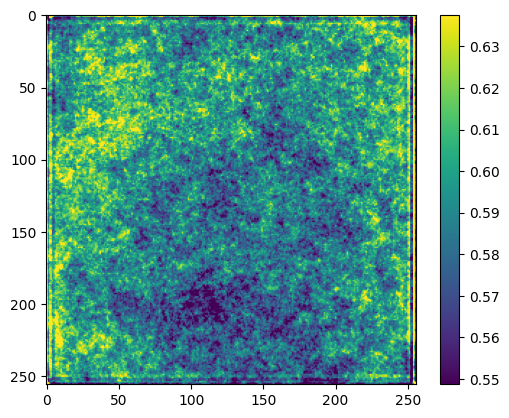

In [7]:
unmask = False
process(unmask)

HS_Davos_20170316_2m_epsg2056


100%|██████████| 886/886 [01:49<00:00,  8.06it/s]


tensor(1.6408, dtype=torch.float64)


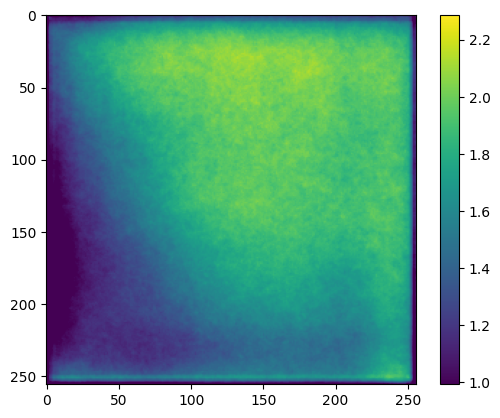

In [8]:
unmask = True
process(unmask)